In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
import pandas as pd

## Prepare for Dataset

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


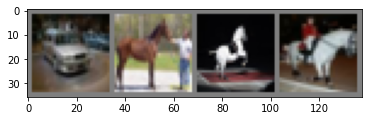

  car horse horse horse


In [27]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Choose a Device

In [28]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


## Network Architecture

In [5]:
class Base_Net(nn.Module):
    def __init__(self):
        super(Base_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.lin1 = nn.Linear(1280, 100)
        self.lin2 = nn.Linear(100, 10)
        
        
        
    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (2,2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

class Net_A(nn.Module):
    def __init__(self):
        super(Net_A, self).__init__()
        self.conv1 = nn.Conv2d(3, 15, 3, 1, 1)
        self.conv2 = nn.Conv2d(15, 25, 2, 1, 1)
        self.lin1 = nn.Linear(1600, 100)
        self.lin2 = nn.Linear(100, 10)
        
        
        
    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (2,2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

class Net_B(nn.Module):
    def __init__(self):
        super(Net_B, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 30, 3, 1, 1)
        self.lin1 = nn.Linear(480, 100)
        self.lin2 = nn.Linear(100, 10)
        
        
        
    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.avg_pool2d(F.relu(self.conv3(x)), (2,2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

class Net_C(nn.Module):
    def __init__(self):
        super(Net_C, self).__init__()
        self.conv1 = nn.Conv2d(3, 15, 3, 1, 1)
        self.conv2 = nn.Conv2d(15, 25, 3, 1, 1)
        self.conv3 = nn.Conv2d(25, 35, 3, 1, 1)
        self.lin1 = nn.Linear(560, 100)
        self.lin2 = nn.Linear(100, 10)
        
        
        
    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.avg_pool2d(F.relu(self.conv3(x)), (2,2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

#### Training Procedure

In [30]:
loss_func = nn.CrossEntropyLoss()

def train(net, epoch=10, optimizer='adam'):
    avg_losses = []
    epochs = epoch
    log_freq = 1000
    if optimizer=='sgd':
        opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
    elif optimizer=='adam':
        opt = optim.Adam(net.parameters(), lr=0.001) 
    else:
        return 'invalid optimizer'
    
    for epoch in trange(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()
            if i % log_freq == log_freq - 1:
                avg_loss = running_loss / log_freq
                avg_losses.append(avg_loss)
                running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return avg_losses, correct/total

def test_acc(net):
    total = 0
    correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

**Baseline Net**

100%|██████████| 10/10 [07:10<00:00, 43.00s/it]


baseline net training accuracy: 0.8278
baseline net test accuracy: 0.6511


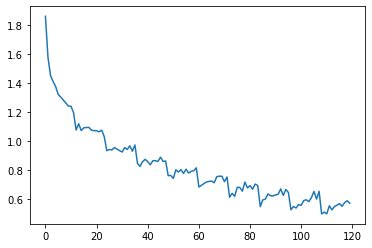

In [7]:
base_net = Base_Net()
base_net.to(device)
base_losses, base_train_score = train(base_net)
base_test_score = test_acc(base_net)
plt.plot(range(len(base_losses)), base_losses)
print(f'baseline net training accuracy: {base_train_score}')
print(f'baseline net test accuracy: {base_test_score}')

**Net A**

100%|██████████| 10/10 [06:47<00:00, 40.76s/it]


net A training accuracy: 0.81558
net A test accuracy: 0.6698


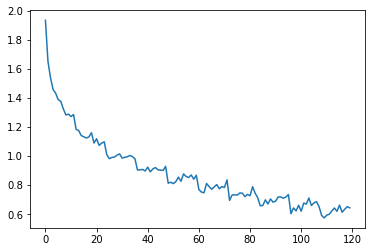

In [8]:
net_a = Net_A()
net_a.to(device)
a_losses, a_train_score = train(net_a)
a_test_score = test_acc(net_a)
plt.plot(range(len(a_losses)), a_losses)
print(f'net A training accuracy: {a_train_score}')
print(f'net A test accuracy: {a_test_score}')

**Net B**

100%|██████████| 10/10 [07:35<00:00, 45.59s/it]


net B training accuracy: 0.76832
net B test accuracy: 0.6922


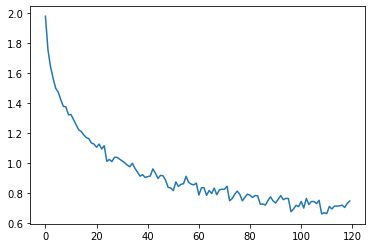

In [9]:
net_b = Net_B()
net_b.to(device)
b_losses, b_train_score = train(net_b)
b_test_score = test_acc(net_b)
plt.plot(range(len(b_losses)), b_losses)
print(f'net B training accuracy: {b_train_score}')
print(f'net B test accuracy: {b_test_score}')

**Net C**

100%|██████████| 10/10 [07:37<00:00, 45.77s/it]


net C training accuracy: 0.79656
net C test accuracy: 0.7041


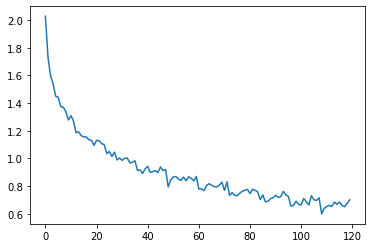

In [10]:
net_c = Net_C()
net_c.to(device)
c_losses, c_train_score = train(net_c)
c_test_score = test_acc(net_c)
plt.plot(range(len(c_losses)), c_losses)
print(f'net C training accuracy: {c_train_score}')
print(f'net C test accuracy: {c_test_score}')

## Hyperparameter Tuning

In [11]:
class Net(nn.Module):
    def __init__(self, pool='avg', activation='relu', dropout=0):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.conv1 = nn.Conv2d(3, 15, 3, 1, 1)
        self.conv2 = nn.Conv2d(15, 25, 3, 1, 1)
        self.conv3 = nn.Conv2d(25, 35, 3, 1, 1)
        self.lin1 = nn.Linear(560, 100)
        self.lin2 = nn.Linear(100, 10)
        self.pool = pool
        self.activation = activation
        
    def forward(self, x):
        x = self.dropout(x)
        if self.activation == 'relu':
            x = F.relu(self.conv1(x))
            if self.pool == 'avg':
                x = F.avg_pool2d(x, (2,2))
                x = F.avg_pool2d(F.relu(self.conv2(x)), (2,2))
                x = F.avg_pool2d(F.relu(self.conv3(x)), (2,2))
                x = torch.flatten(x, start_dim=1)
                x = F.relu(self.lin1(x))
                x = self.lin2(x)
            elif self.pool == 'max':
                x = F.max_pool2d(x, (2,2))
                x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
                x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
                x = torch.flatten(x, start_dim=1)
                x = F.relu(self.lin1(x))
                x = self.lin2(x)
        elif self.activation == 'lrelu':
            x = F.leaky_relu(self.conv1(x))
            if self.pool == 'avg':
                x = F.avg_pool2d(x, (2,2))
                x = F.avg_pool2d(F.leaky_relu(self.conv2(x)), (2,2))
                x = F.avg_pool2d(F.leaky_relu(self.conv3(x)), (2,2))
                x = torch.flatten(x, start_dim=1)
                x = F.leaky_relu(self.lin1(x))
                x = self.lin2(x)
            elif self.pool == 'max':
                x = F.max_pool2d(x, (2,2))
                x = F.max_pool2d(F.leaky_relu(self.conv2(x)), (2,2))
                x = F.max_pool2d(F.leaky_relu(self.conv3(x)), (2,2))
                x = torch.flatten(x, start_dim=1)
                x = F.leaky_relu(self.lin1(x))
                x = self.lin2(x)
        else:
            x = F.elu(self.conv1(x))
            if self.pool == 'avg':
                x = F.avg_pool2d(x, (2,2))
                x = F.avg_pool2d(F.elu(self.conv2(x)), (2,2))
                x = F.avg_pool2d(F.elu(self.conv3(x)), (2,2))
                x = torch.flatten(x, start_dim=1)
                x = F.elu(self.lin1(x))
                x = self.lin2(x)
            elif self.pool == 'max':
                x = F.max_pool2d(x, (2,2))
                x = F.max_pool2d(F.elu(self.conv2(x)), (2,2))
                x = F.max_pool2d(F.elu(self.conv3(x)), (2,2))
                x = torch.flatten(x, start_dim=1)
                x = F.elu(self.lin1(x))
                x = self.lin2(x)
        return x

**varying pooling & activation**

In [18]:
pools = ['avg', 'max']
activations = ['relu', 'lrelu', 'elu']
dropouts = [0, 0.15, 0.3, 0.45]
models = []


for a in activations:
    for d in dropouts:
        for p in pools:
            models.append(Net(pool=p, activation=a, dropout=d).to(device))

models

[Net(
   (dropout): Dropout(p=0, inplace=False)
   (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(15, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv3): Conv2d(25, 35, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (lin1): Linear(in_features=560, out_features=100, bias=True)
   (lin2): Linear(in_features=100, out_features=10, bias=True)
 ),
 Net(
   (dropout): Dropout(p=0, inplace=False)
   (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(15, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv3): Conv2d(25, 35, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (lin1): Linear(in_features=560, out_features=100, bias=True)
   (lin2): Linear(in_features=100, out_features=10, bias=True)
 ),
 Net(
   (dropout): Dropout(p=0.15, inplace=False)
   (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(15, 25, kernel_size=(3, 3), s

activation: relu, pooling: avg, dropout: 0


100%|██████████| 10/10 [07:36<00:00, 45.66s/it]


train accuracy: 0.79278; test accuracy: 0.7002
activation: relu, pooling: max, dropout: 0


100%|██████████| 10/10 [07:50<00:00, 47.00s/it]


train accuracy: 0.79812; test accuracy: 0.6947
activation: relu, pooling: avg, dropout: 0.15


100%|██████████| 10/10 [07:45<00:00, 46.56s/it]


train accuracy: 0.73646; test accuracy: 0.6617
activation: relu, pooling: max, dropout: 0.15


100%|██████████| 10/10 [07:57<00:00, 47.79s/it]


train accuracy: 0.72428; test accuracy: 0.651
activation: relu, pooling: avg, dropout: 0.3


100%|██████████| 10/10 [07:44<00:00, 46.43s/it]


train accuracy: 0.70778; test accuracy: 0.6418
activation: relu, pooling: max, dropout: 0.3


100%|██████████| 10/10 [07:55<00:00, 47.59s/it]


train accuracy: 0.66886; test accuracy: 0.6099
activation: relu, pooling: avg, dropout: 0.45


100%|██████████| 10/10 [07:43<00:00, 46.32s/it]


train accuracy: 0.6919; test accuracy: 0.6402
activation: relu, pooling: max, dropout: 0.45


100%|██████████| 10/10 [07:58<00:00, 47.87s/it]


train accuracy: 0.67428; test accuracy: 0.6104
activation: lrelu, pooling: avg, dropout: 0


100%|██████████| 10/10 [07:54<00:00, 47.48s/it]


train accuracy: 0.85142; test accuracy: 0.7011
activation: lrelu, pooling: max, dropout: 0


100%|██████████| 10/10 [07:54<00:00, 47.44s/it]


train accuracy: 0.83356; test accuracy: 0.6915
activation: lrelu, pooling: avg, dropout: 0.15


100%|██████████| 10/10 [07:48<00:00, 46.89s/it]


train accuracy: 0.78734; test accuracy: 0.6747
activation: lrelu, pooling: max, dropout: 0.15


100%|██████████| 10/10 [07:55<00:00, 47.60s/it]


train accuracy: 0.75334; test accuracy: 0.6562
activation: lrelu, pooling: avg, dropout: 0.3


100%|██████████| 10/10 [07:43<00:00, 46.37s/it]


train accuracy: 0.77726; test accuracy: 0.6725
activation: lrelu, pooling: max, dropout: 0.3


100%|██████████| 10/10 [07:50<00:00, 47.03s/it]


train accuracy: 0.72258; test accuracy: 0.6422
activation: lrelu, pooling: avg, dropout: 0.45


100%|██████████| 10/10 [07:44<00:00, 46.41s/it]


train accuracy: 0.72422; test accuracy: 0.6318
activation: lrelu, pooling: max, dropout: 0.45


100%|██████████| 10/10 [07:49<00:00, 46.95s/it]


train accuracy: 0.68468; test accuracy: 0.6092
activation: elu, pooling: avg, dropout: 0


100%|██████████| 10/10 [07:38<00:00, 45.80s/it]


train accuracy: 0.84364; test accuracy: 0.6858
activation: elu, pooling: max, dropout: 0


100%|██████████| 10/10 [07:50<00:00, 47.08s/it]


train accuracy: 0.84482; test accuracy: 0.7006
activation: elu, pooling: avg, dropout: 0.15


100%|██████████| 10/10 [07:55<00:00, 47.59s/it]


train accuracy: 0.78016; test accuracy: 0.6728
activation: elu, pooling: max, dropout: 0.15


100%|██████████| 10/10 [08:02<00:00, 48.29s/it]


train accuracy: 0.75838; test accuracy: 0.6615
activation: elu, pooling: avg, dropout: 0.3


100%|██████████| 10/10 [07:47<00:00, 46.80s/it]


train accuracy: 0.74818; test accuracy: 0.6524
activation: elu, pooling: max, dropout: 0.3


100%|██████████| 10/10 [07:56<00:00, 47.65s/it]


train accuracy: 0.72874; test accuracy: 0.6432
activation: elu, pooling: avg, dropout: 0.45


100%|██████████| 10/10 [07:48<00:00, 46.90s/it]


train accuracy: 0.71118; test accuracy: 0.6268
activation: elu, pooling: max, dropout: 0.45


100%|██████████| 10/10 [08:03<00:00, 48.36s/it]


train accuracy: 0.70576; test accuracy: 0.6237


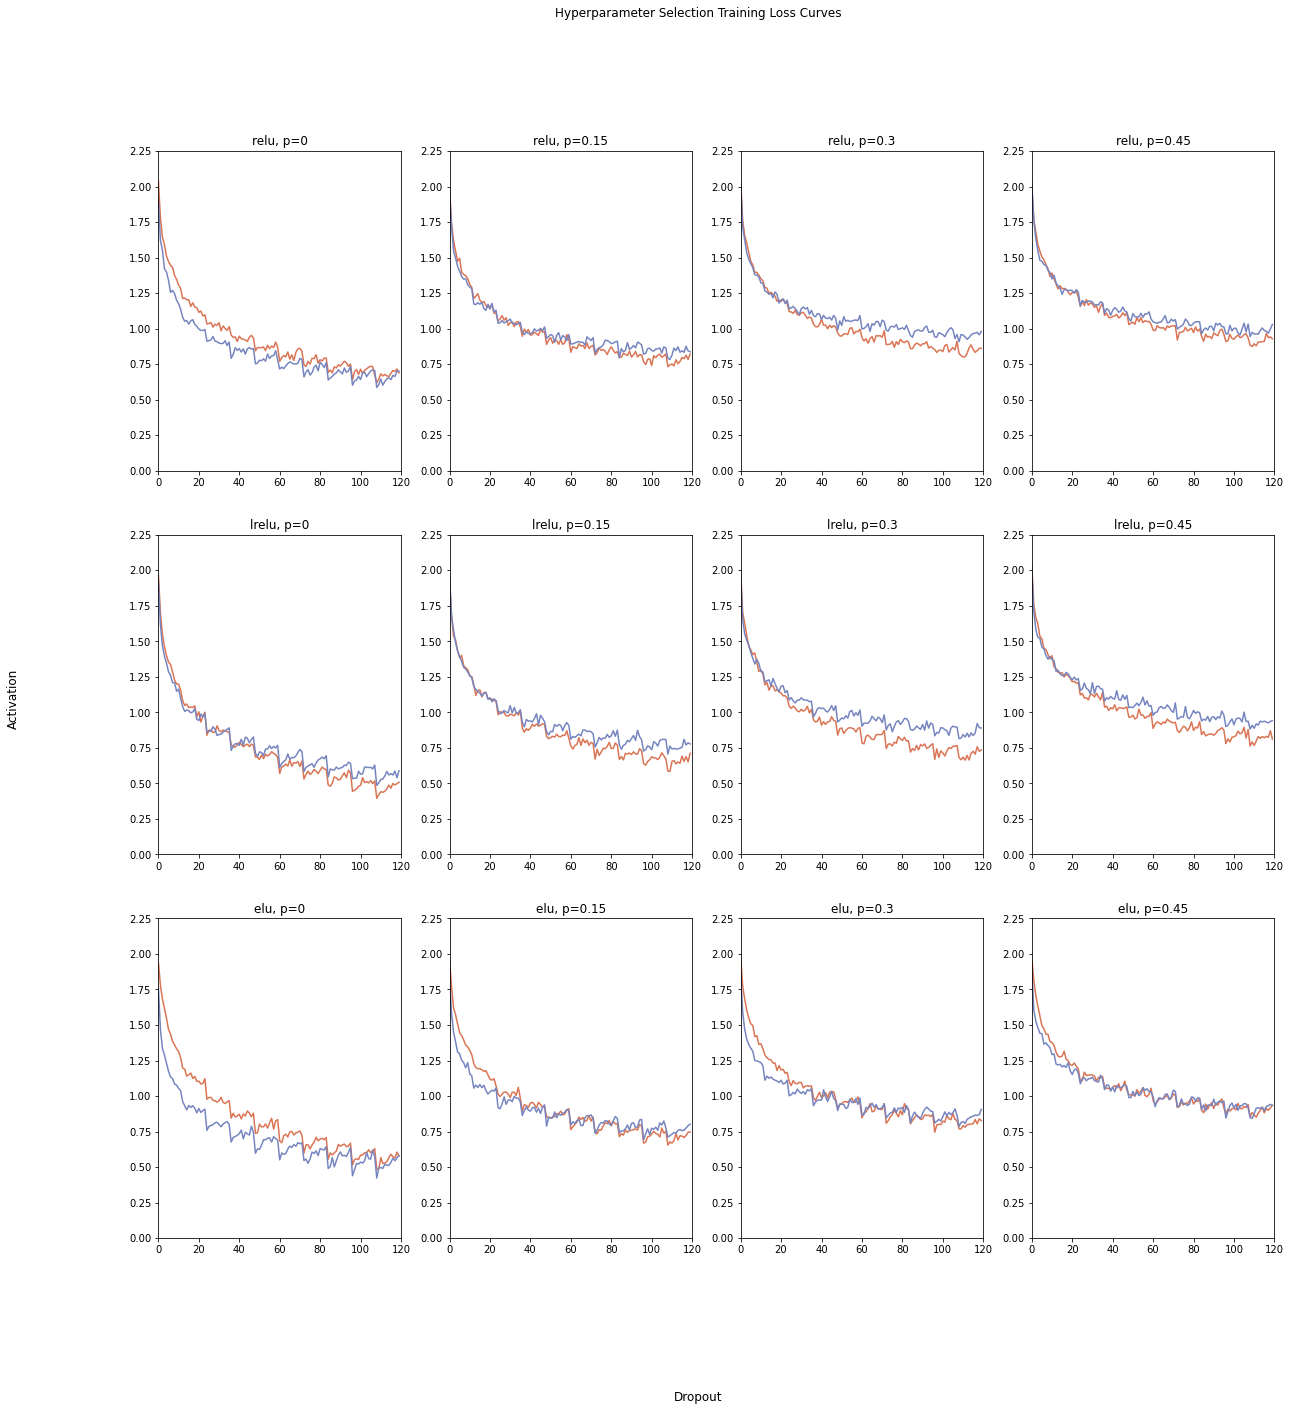

In [19]:
results = {
    'activation': [],
    'dropout': [],
    'pooling': [],
    'train accuracy': [],
    'test accuracy': []
}

fig, axs = plt.subplots(len(activations),len(dropouts),figsize=(20, 20))
fig.suptitle('Hyperparameter Selection Training Loss Curves')
fig.supxlabel('Dropout')
fig.supylabel('Activation')
colors = ['#da7454','#7685c0']

for model in models:
    print(f'activation: {model.activation}, pooling: {model.pool}, dropout: {model.dropout.p}')
    losses, train_score = train(model)
    test_score = test_acc(model)
    results['activation'].append(model.activation)
    results['pooling'].append(model.pool)
    results['dropout'].append(model.dropout.p)
    results['train accuracy'].append(train_score)
    results['test accuracy'].append(test_score)
    print(f'train accuracy: {train_score}; test accuracy: {test_score}')
    
    #plotting
    i = activations.index(model.activation)
    j = dropouts.index(model.dropout.p)
    c = colors[pools.index(model.pool)]
    axs[i,j].set_xlim(left=0, right=len(losses))
    axs[i,j].set_ylim(bottom=0, top=2.25)
    axs[i,j].plot(range(len(losses)), losses, color=c)
    axs[i,j].set_title(f'{model.activation}, p={model.dropout.p}')
    

In [20]:
df = pd.DataFrame(results)

In [23]:
df.sort_values('test accuracy', ascending=False)

,activation,dropout,pooling,train accuracy,test accuracy
8,lrelu,0.00,avg,0.85142,0.7011
17,elu,0.00,max,0.84482,0.7006
0,relu,0.00,avg,0.79278,0.7002
1,relu,0.00,max,0.79812,0.6947
9,lrelu,0.00,max,0.83356,0.6915
16,elu,0.00,avg,0.84364,0.6858
10,lrelu,0.15,avg,0.78734,0.6747
18,elu,0.15,avg,0.78016,0.6728
12,lrelu,0.30,avg,0.77726,0.6725
2,relu,0.15,avg,0.73646,0.6617


In [24]:
results_1 = {
    'activation': [],
    'pooling': [],
    'train accuracy': [],
    'test accuracy': []
}

for a in activations:
    for p in pools:        
        train_score = 0
        test_score = 0
        for i in range(3):
            print(f'activation: {a}, pooling: {p} ({i+1}/3)')
            model = Net(pool=p, activation=a, dropout=0).to(device)
            
            losses, tr = train(model)
            train_score += tr
            test_score += test_acc(model)
        
        train_score = train_score / 3
        test_score = test_score / 3
        
        results_1['activation'].append(a)
        results_1['pooling'].append(p)
        results_1['train accuracy'].append(train_score)
        results_1['test accuracy'].append(test_score)
        print(f'train accuracy: {train_score}; test accuracy: {test_score}')

activation: relu, pooling: avg (1/3)


100%|██████████| 10/10 [07:44<00:00, 46.45s/it]


activation: relu, pooling: avg (2/3)


100%|██████████| 10/10 [07:45<00:00, 46.56s/it]


activation: relu, pooling: avg (3/3)


100%|██████████| 10/10 [07:45<00:00, 46.57s/it]


train accuracy: 0.7991866666666666; test accuracy: 0.7039333333333332
activation: relu, pooling: max (1/3)


100%|██████████| 10/10 [07:48<00:00, 46.81s/it]


activation: relu, pooling: max (2/3)


100%|██████████| 10/10 [07:48<00:00, 46.90s/it]


activation: relu, pooling: max (3/3)


100%|██████████| 10/10 [07:49<00:00, 46.93s/it]


train accuracy: 0.7810266666666666; test accuracy: 0.6838666666666667
activation: lrelu, pooling: avg (1/3)


100%|██████████| 10/10 [07:39<00:00, 45.98s/it]


activation: lrelu, pooling: avg (2/3)


100%|██████████| 10/10 [07:37<00:00, 45.73s/it]


activation: lrelu, pooling: avg (3/3)


100%|██████████| 10/10 [07:39<00:00, 45.98s/it]


train accuracy: 0.8618733333333334; test accuracy: 0.7044333333333332
activation: lrelu, pooling: max (1/3)


100%|██████████| 10/10 [07:51<00:00, 47.14s/it]


activation: lrelu, pooling: max (2/3)


100%|██████████| 10/10 [08:17<00:00, 49.74s/it]


activation: lrelu, pooling: max (3/3)


100%|██████████| 10/10 [08:11<00:00, 49.19s/it]


train accuracy: 0.8280799999999999; test accuracy: 0.6966666666666667
activation: elu, pooling: avg (1/3)


100%|██████████| 10/10 [07:58<00:00, 47.83s/it]


activation: elu, pooling: avg (2/3)


100%|██████████| 10/10 [07:58<00:00, 47.81s/it]


activation: elu, pooling: avg (3/3)


100%|██████████| 10/10 [08:01<00:00, 48.10s/it]


train accuracy: 0.8390466666666666; test accuracy: 0.6775333333333333
activation: elu, pooling: max (1/3)


100%|██████████| 10/10 [08:12<00:00, 49.28s/it]


activation: elu, pooling: max (2/3)


100%|██████████| 10/10 [08:12<00:00, 49.26s/it]


activation: elu, pooling: max (3/3)


100%|██████████| 10/10 [08:10<00:00, 49.06s/it]


train accuracy: 0.8452133333333333; test accuracy: 0.6983666666666667


In [26]:
pd.DataFrame(results_1).sort_values('test accuracy', ascending=False)

,activation,pooling,train accuracy,test accuracy
2,lrelu,avg,0.861873,0.704433
0,relu,avg,0.799187,0.703933
5,elu,max,0.845213,0.698367
3,lrelu,max,0.828080,0.696667
1,relu,max,0.781027,0.683867
4,elu,avg,0.839047,0.677533


In [43]:
class Final_Net(nn.Module):
    def __init__(self):
        super(Final_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 15, 3, 1, 1)
        self.conv2 = nn.Conv2d(15, 25, 3, 1, 1)
        self.conv3 = nn.Conv2d(25, 35, 3, 1, 1)
        self.lin1 = nn.Linear(560, 100)
        self.lin2 = nn.Linear(100, 10)
           
    def forward(self, x):
        x = F.avg_pool2d(F.leaky_relu(self.conv1(x)), (2,2))
        x = F.avg_pool2d(F.leaky_relu(self.conv2(x)), (2,2))
        x = F.avg_pool2d(F.leaky_relu(self.conv3(x)), (2,2))
        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [44]:
final_net = Final_Net()
final_net.to(device)

final_losses, final_train_score = train(final_net, epoch=10)
final_test_score = test_acc(final_net)

100%|██████████| 10/10 [07:38<00:00, 45.82s/it]


training error: 0.85954
test error: 0.7206


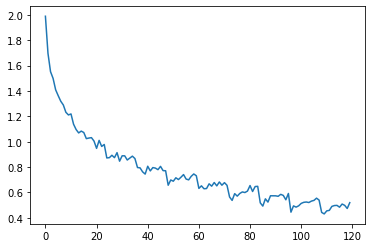

In [45]:
print(f'training error: {final_train_score}')
print(f'test error: {final_test_score}')
plt.plot(range(len(final_losses)), final_losses)

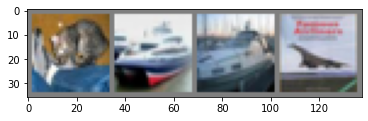

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [46]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = final_net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [47]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = final_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 82 %
Accuracy of  bird : 62 %
Accuracy of   cat : 53 %
Accuracy of  deer : 67 %
Accuracy of   dog : 53 %
Accuracy of  frog : 77 %
Accuracy of horse : 76 %
Accuracy of  ship : 82 %
Accuracy of truck : 83 %
